=== ETAP 0: WCZYTYWANIE DANYCH ===
Wykryto plik w środowisku. Wczytuję...
Wczytano 30 rekordów.

[WYKRES 1] Definicja pojęć rozmytych (Fuzzy Sets):


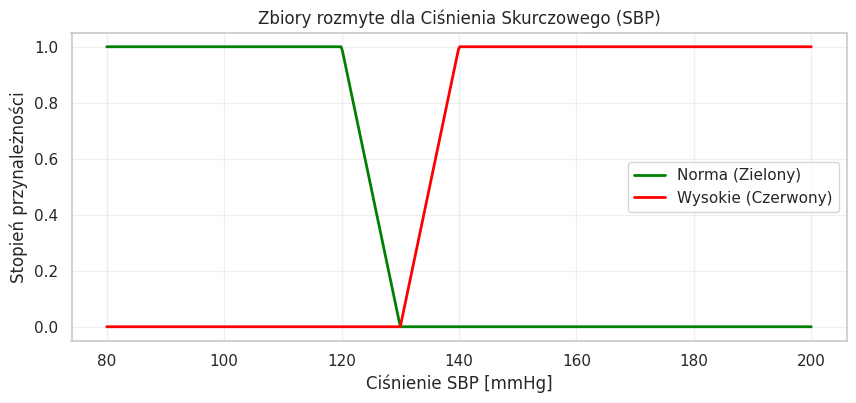


[WYKRES 2] Rozkład ryzyka zdrowotnego w badanej grupie:


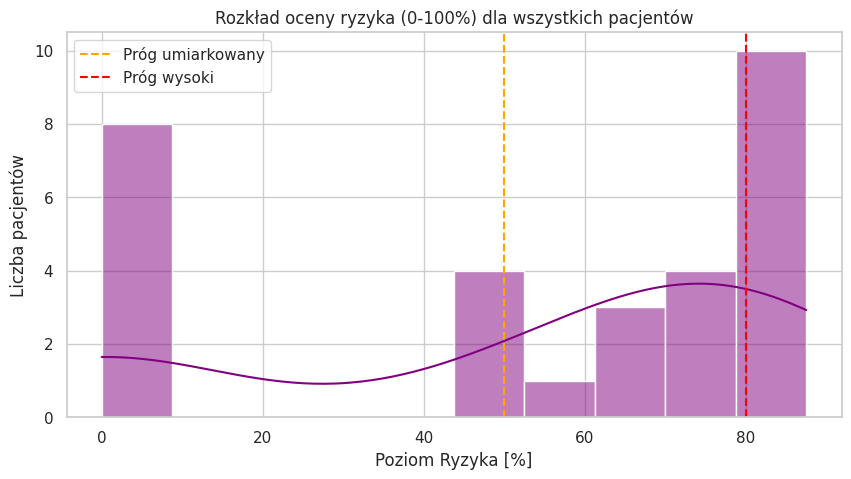


[WYKRES 3] Wyjaśnienie diagnozy dla pacjenta o najwyższym ryzyku (P06):
Dane: Wiek=79, SBP=155, Ryzyko=87.5%


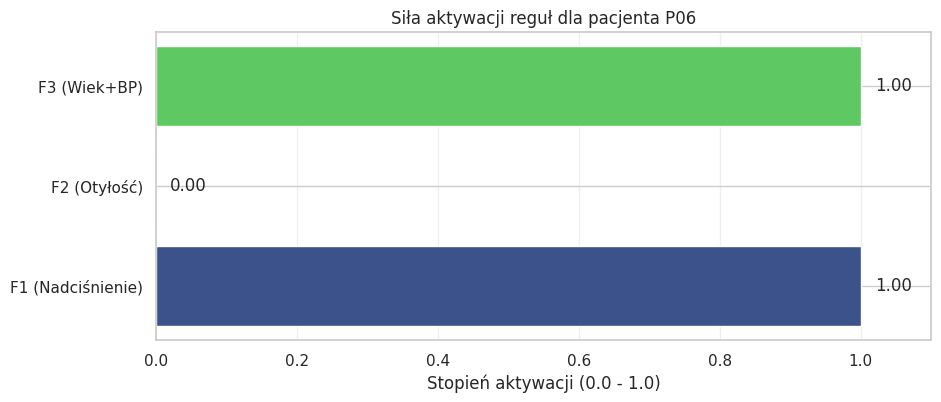

In [2]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia wykresów
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# ==========================================
# 1. MECHANIZM WCZYTYWANIA DANYCH
# ==========================================
print("=== ETAP 0: WCZYTYWANIE DANYCH ===")
try:
    from google.colab import files
    # Sprawdzamy czy plik już jest, żeby nie wgrywać go za każdym razem przy testach
    import os
    if not os.path.exists('pacjenci_demo_system_ekspertowy.csv'):
        print("Proszę wybrać plik CSV z dysku:")
        uploaded = files.upload()
        filename = next(iter(uploaded))
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
    else:
        print("Wykryto plik w środowisku. Wczytuję...")
        df = pd.read_csv('pacjenci_demo_system_ekspertowy.csv')
except ImportError:
    print("Środowisko lokalne. Wczytuję plik z dysku...")
    df = pd.read_csv('pacjenci_demo_system_ekspertowy.csv')

print(f"Wczytano {len(df)} rekordów.")

# ==========================================
# 2. SYSTEM KLASYCZNY
# ==========================================
class ClassicExpertSystem:
    def __init__(self):
        self.rules = [
            {"id": "R1", "name": "Nadciśnienie", "if": lambda p: p["systolic_bp"] >= 140 or p["diastolic_bp"] >= 90, "weight": 0.9},
            {"id": "R2", "name": "Otyłość", "if": lambda p: p["bmi"] >= 30, "weight": 0.8},
            {"id": "R3", "name": "Cukrzyca", "if": lambda p: p["glucose"] >= 126, "weight": 0.85},
            {"id": "R4", "name": "Ryzyko sercowo-naczyniowe", "if": lambda p: p["age"] >= 65 and p["systolic_bp"] >= 140, "weight": 0.7}
        ]

    def evaluate(self, patient):
        conclusions = {}
        for rule in self.rules:
            if rule["if"](patient):
                conclusions[rule["name"]] = rule["weight"]
        return conclusions

# ==========================================
# 3. SYSTEM ROZMYTY (Fuzzy Logic) + XAI
# ==========================================
class FuzzyExpertSystem:
    def trapmf(self, x, a, b, c, d):
        return max(min((x - a) / (b - a + 1e-9), 1, (d - x) / (d - c + 1e-9)), 0)

    def fuzzify(self, patient):
        vals = {}
        # SBP
        vals['sbp_norm'] = self.trapmf(patient['systolic_bp'], 0, 0, 120, 130)
        vals['sbp_high'] = self.trapmf(patient['systolic_bp'], 130, 140, 300, 300)
        # BMI
        vals['bmi_norm'] = self.trapmf(patient['bmi'], 0, 0, 25, 27)
        vals['bmi_high'] = self.trapmf(patient['bmi'], 27, 30, 100, 100)
        # Age
        vals['age_old']  = self.trapmf(patient['age'], 60, 70, 150, 150)
        return vals

    def infer(self, patient):
        f = self.fuzzify(patient)
        rules = []

        # Reguły
        rules.append({"id": "F1 (Nadciśnienie)", "act": f['sbp_high'], "out": 80})
        rules.append({"id": "F2 (Otyłość)", "act": f['bmi_high'], "out": 50})
        rules.append({"id": "F3 (Wiek+BP)", "act": min(f['age_old'], f['sbp_high']), "out": 95})

        # Agregacja
        num, den = 0, 0
        for r in rules:
            num += r["act"] * r["out"]
            den += r["act"]

        risk = num / den if den > 0 else 0
        return risk, rules

    # --- NOWOŚĆ: Wizualizacja funkcji przynależności ---
    def plot_membership_functions(self):
        x_sbp = np.linspace(80, 200, 500)
        y_norm = [self.trapmf(i, 0, 0, 120, 130) for i in x_sbp]
        y_high = [self.trapmf(i, 130, 140, 300, 300) for i in x_sbp]

        plt.figure(figsize=(10, 4))
        plt.plot(x_sbp, y_norm, label='Norma (Zielony)', color='green', linewidth=2)
        plt.plot(x_sbp, y_high, label='Wysokie (Czerwony)', color='red', linewidth=2)
        plt.title("Zbiory rozmyte dla Ciśnienia Skurczowego (SBP)")
        plt.xlabel("Ciśnienie SBP [mmHg]")
        plt.ylabel("Stopień przynależności")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# ==========================================
# 4. GŁÓWNA ANALIZA I WYKRESY
# ==========================================

classic = ClassicExpertSystem()
fuzzy = FuzzyExpertSystem()
results = []

# Przetwarzanie wszystkich pacjentów
for idx, row in df.iterrows():
    p = row.to_dict()
    pid = p.get('patient_id', f"P{idx}")
    risk, explanations = fuzzy.infer(p)
    results.append({
        "ID": pid,
        "Ryzyko": risk,
        "Wiek": p['age'],
        "SBP": p['systolic_bp'],
        "Explanations": explanations
    })

results_df = pd.DataFrame(results)

# --- WYKRES 1: Funkcje przynależności ---
print("\n[WYKRES 1] Definicja pojęć rozmytych (Fuzzy Sets):")
fuzzy.plot_membership_functions()

# --- WYKRES 2: Histogram ryzyka w populacji ---
print("\n[WYKRES 2] Rozkład ryzyka zdrowotnego w badanej grupie:")
plt.figure(figsize=(10, 5))
sns.histplot(results_df['Ryzyko'], bins=10, kde=True, color='purple')
plt.title("Rozkład oceny ryzyka (0-100%) dla wszystkich pacjentów")
plt.xlabel("Poziom Ryzyka [%]")
plt.ylabel("Liczba pacjentów")
plt.axvline(x=50, color='orange', linestyle='--', label='Próg umiarkowany')
plt.axvline(x=80, color='red', linestyle='--', label='Próg wysoki')
plt.legend()
plt.show()

# --- WYKRES 3: XAI - Analiza konkretnego pacjenta ---
# Wybieramy pacjenta z najwyższym ryzykiem
high_risk_patient = results_df.loc[results_df['Ryzyko'].idxmax()]
print(f"\n[WYKRES 3] Wyjaśnienie diagnozy dla pacjenta o najwyższym ryzyku ({high_risk_patient['ID']}):")
print(f"Dane: Wiek={high_risk_patient['Wiek']}, SBP={high_risk_patient['SBP']}, Ryzyko={high_risk_patient['Ryzyko']:.1f}%")

# Przygotowanie danych do wykresu XAI
rules_data = high_risk_patient['Explanations']
rule_names = [r['id'] for r in rules_data]
rule_acts = [r['act'] for r in rules_data]

plt.figure(figsize=(10, 4))
colors = sns.color_palette("viridis", len(rule_names))
bars = plt.barh(rule_names, rule_acts, color=colors)
plt.title(f"Siła aktywacji reguł dla pacjenta {high_risk_patient['ID']}")
plt.xlabel("Stopień aktywacji (0.0 - 1.0)")
plt.xlim(0, 1.1)

# Dodanie wartości na słupkach
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.grid(axis='x', alpha=0.3)
plt.show()